# ASI assessed exercise 2016/2017 (Work in Progress)
5th May 2017

## Introduction and Instructions

In this work you will analyze the MNIST and CIFAR10 datasets available to download from:
- http://yann.lecun.com/exdb/mnist/
- https://www.cs.toronto.edu/~kriz/cifar.html

# Exercises
Note (code) and (text) before each task indicate whether the corresponding part involves coding or writing.

<div class="alert alert-info">
1) (code) Download the MNIST and CIFAR10 datasets and import them. [3]
</div>

In [34]:
import numpy as np
import pandas as pd
import scipy
from sklearn.metrics import confusion_matrix, log_loss, mean_squared_error

from time import time
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import mnist, cifar10

In [35]:
(mnist_train_data, mnist_train_label), (mnist_test_data, mnist_test_label) = mnist.load_data()
(cifar_train_data, cifar_train_label), (cifar_test_data, cifar_test_label) = cifar10.load_data()

<div class="alert alert-info">
2) (text) Comment on the distribution of class labels and the dimensionality of the input and how these may affect the analysis. [7]
</div>

Let's see the labels distribution.

In [36]:
mnist_num_samples = len(mnist_train_data)
mnist_unique, mnist_counts = np.unique(mnist_train_label, return_counts=True)
mnist_label_prob = dict(zip(mnist_unique, mnist_counts/mnist_num_samples))
mnist_label_prob

{0: 0.098716666666666661,
 1: 0.11236666666666667,
 2: 0.099299999999999999,
 3: 0.10218333333333333,
 4: 0.097366666666666671,
 5: 0.09035,
 6: 0.098633333333333337,
 7: 0.10441666666666667,
 8: 0.097516666666666668,
 9: 0.099150000000000002}

In [37]:
cifar_num_samples = len(cifar_train_data)
cifar_unique, cifar_counts = np.unique(cifar_train_label, return_counts=True)
cifar_label_prob = dict(zip(cifar_unique, cifar_counts/cifar_num_samples))
cifar_label_prob

{0: 0.10000000000000001,
 1: 0.10000000000000001,
 2: 0.10000000000000001,
 3: 0.10000000000000001,
 4: 0.10000000000000001,
 5: 0.10000000000000001,
 6: 0.10000000000000001,
 7: 0.10000000000000001,
 8: 0.10000000000000001,
 9: 0.10000000000000001}

Defining $K$ as the number of different labels we can have in our dataset and $k = 0,1,2, ..., K-1 $, with MNIST we notice that 
$$
P(t = k) \approx \dfrac{1}{K}
$$
while with CIFAR10 we have:
$$
P(t = k) = \dfrac{1}{K}.
$$
In both cases, we can assume that the prior is constant.

# Data pre-processing 

## Reshaping

Let's see the dimensionality of the input.

In [38]:
print(mnist_train_data.shape)
print(cifar_train_data.shape)

(60000, 28, 28)
(50000, 32, 32, 3)


We need to flatten each sample.

In [39]:
mnist_train_data = mnist_train_data.reshape(mnist_num_samples, -1)
cifar_train_data = cifar_train_data.reshape(cifar_num_samples, -1)

print(mnist_train_data.shape)
print(cifar_train_data.shape)


(60000, 784)
(50000, 3072)


The dimensionality of the input for CIFAR10 is very high, 3072. This means classification might be difficult and we probably need more training data to get good results. Here using PCA could be a possible improvement.

In [40]:
mnist_test_data = mnist_test_data.reshape(len(mnist_test_data), -1)
print(mnist_test_data.shape)

cifar_test_data = cifar_test_data.reshape(len(cifar_test_data), -1)
print(cifar_test_data.shape)

(10000, 784)
(10000, 3072)


## Normalizing

Working with small numbers could help avoiding overflows and long computational time, so we normalize.

In [41]:
mnist_train_data_norm = mnist_train_data/255
mnist_test_data_norm = mnist_test_data/255

cifar_train_data_norm = cifar_train_data/255
cifar_test_data_norm = cifar_test_data/255


<div class="alert alert-info">
<h2>3) Classification</h2>
<br>
a) (code) Implement the Na誰ve Bayes classifier. [10]
</div>

## Splitting the samples by label

In [9]:
# Group the data by labels
mnist_K = len(mnist_unique)
cifar_K = len(cifar_unique)
mnist_train_data_label_norm = [mnist_train_data_norm, mnist_train_label] # [1] for label, [0][6] for 7-th sample
mnist_train_splitted_labels_norm = {}

mnist_test_data_label_norm = [mnist_test_data_norm, mnist_test_label] # [1] for label, [0][6] for 7-th sample
mnist_test_splitted_labels_norm = {}

cifar_train_data_label_norm = [cifar_train_data_norm, cifar_train_label]
cifar_train_splitted_labels_norm = {}

cifar_test_data_label_norm = [cifar_test_data_norm, cifar_test_label]
cifar_test_splitted_labels_norm = {}

def split_data(data, data_label, K):
    splitted_labels = {}
    for k in range(K):
        splitted_labels[k] = []
    for i in range(len(data)):
        for k in range(K):
            if data_label[1][i] == k:
                splitted_labels[k].append(data_label[0][i]) # [7] list of all 7-labeled images
    return splitted_labels

mnist_train_splitted_labels_norm = split_data(mnist_train_data_norm, mnist_train_data_label_norm, mnist_K)
cifar_train_splitted_labels_norm = split_data(cifar_train_data_norm, cifar_train_data_label_norm, mnist_K)

mnist_test_splitted_labels_norm = split_data(mnist_test_data_norm, mnist_test_data_label_norm, mnist_K)
cifar_test_splitted_labels_norm = split_data(cifar_test_data_norm, cifar_test_data_label_norm, mnist_K)

## Defining functions for prediction

In [10]:
def get_means_vars(samples_):
    """
    given all the samples, it returns means and vars in a dictionary with label as index
    means_[k] is an array (784,)
    """
    epsilon = 1e-3 # to avoid division by zero, chosen arbitrarily
    means_, vars_ = {}, {}
    for k in range(len(samples_)): 
        tmp = np.array(samples_[k])
        means_[k] = tmp.mean(axis=0)
        vars_[k] = tmp.var(axis=0) + epsilon
    return means_, vars_
    
def likelihood(sample, means_k, vars_k):
    """
    likelihood of an image
    product of a sequence sampled from a normal
    """
    return np.prod(np.float128(np.exp(-(sample - means_k)**2/(2*(vars_k))) / (np.sqrt(2*np.pi*vars_k))))

def probability_k(sample, k, dataset='mnist'):
    """
    probability that a sample is k-labeled
    """
    global new_sample, prev_den # to avoid computation

    if dataset=='cifar':
        means_, vars_, K = cifar_means_, cifar_vars_, cifar_K
    else: 
        means_, vars_, K = mnist_means_, mnist_vars_, mnist_K
    LH = likelihood(sample, means_[k], vars_[k])
    num = LH*.1 
    # the denominator is just a normalization constant, we don't need it for the max
    if new_sample == 1:
        den = 0
        for j in range(K):
            den += likelihood(sample, means_[j], vars_[j])*.1
        prev_den = den
    else:
        den = prev_den
    return num/den
    return num

new_sample, prev_den = 0, 0
mnist_means_, mnist_vars_ = get_means_vars(mnist_train_splitted_labels_norm)
cifar_means_, cifar_vars_ = get_means_vars(cifar_train_splitted_labels_norm)

In [11]:
def predict(data, labels, dataset='mnist', perc=10):
    global new_sample, prev_den 
    correct = 0
    perc = perc/100
    total = int(len(data)*perc)
    predicted_labels = np.zeros(total)
    
    print("Predicting %d images from %s..." % (total, dataset))
    t0 = time()
    probabilities = []
    new_sample, prev_den = 0, 0
    for sample in range(total):
        new_sample = 1
        probabilities_sample = []
        for k in range(10):
            true_label =  labels[sample]
            probabilities_sample.append(probability_k(data[sample], k, dataset))
            new_sample = 0
        predicted_label = probabilities_sample.index(max(probabilities_sample))
        predicted_labels[sample] = int(predicted_label)
        if predicted_label == true_label:
            correct += 1
        probabilities.append(probabilities_sample)
            
    print("Time for %d samples: %.2f" % (total, time()-t0))
    print("Accuracy: ",(correct/total))
    print("Log loss:",log_loss(labels, np.array(probabilities)))
    return predicted_labels

<div class="alert alert-info">

b) (text) Describe a positive and a negative feature of the classifier for these tasks [5]
</div>
Positive feature: non-parametric model and not heavy in computation.

Negative feature: too simple and does not work with datasets with high dimensionality.
<div class="alert alert-info">
c) (text) Describe any data pre-processing that you suggest for this data and your classifier [5]
</div>
As seen above, we flattened the image pixels into an 1-dimensional array, then normalized it.
<div class="alert alert-info">
d) (code) Apply your classifier to the two given datasets. Make sure your optimization is clearly commented. Use classification accuracy and test log-likelihood as your figures of merit [15]
</div>
Let's test on the whole MNIST test set, then on the CIFAR.

In [12]:
mnist_predicted_labels = predict(mnist_test_data_norm, mnist_test_label, dataset='mnist',perc=100)

Predicting 10000 images from mnist...
Time for 10000 samples: 6.52
Accuracy:  0.7746
Log loss: 6.46458241859


In [13]:
cifar_predicted_labels = predict(cifar_test_data_norm, cifar_test_label, 'cifar', 100)

Predicting 10000 images from cifar...
Time for 10000 samples: 20.66
Accuracy:  0.296
Log loss: 23.5892871509


<div class="alert alert-info">
e) (code) Display the confusion matrix on the test data [5]
</div>

In [14]:
mnist_conf_matrix = confusion_matrix(mnist_test_label[:len(mnist_predicted_labels)], mnist_predicted_labels)
cifar_conf_matrix = confusion_matrix(cifar_test_label[:len(cifar_predicted_labels)], cifar_predicted_labels)

In [101]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

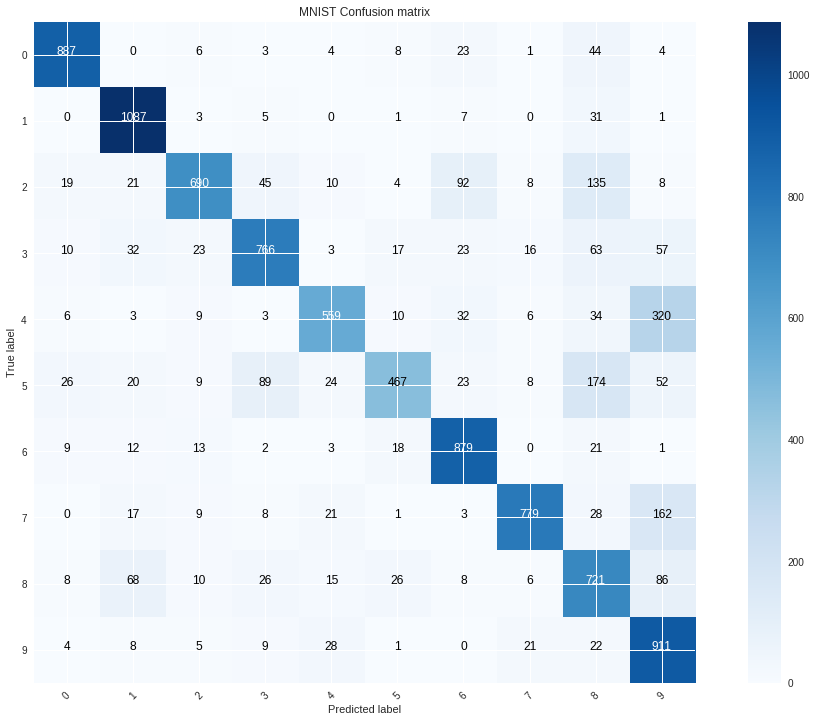

In [16]:
# Compute confusion matrix
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,10))
plot_confusion_matrix(mnist_conf_matrix, classes=range(10),
                      title='MNIST Confusion matrix')
plt.show()

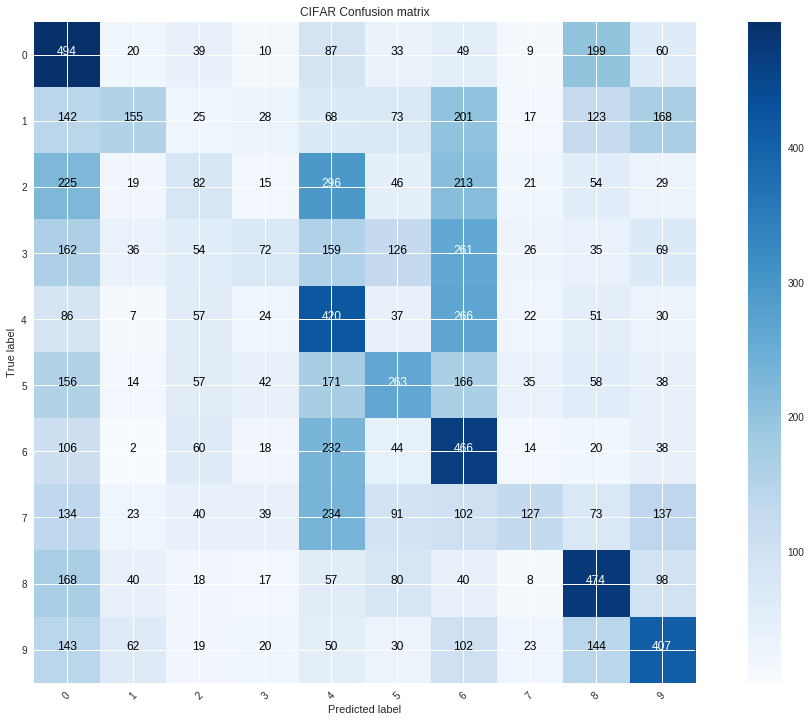

In [17]:
# Compute confusion matrix
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,10))
plot_confusion_matrix(cifar_conf_matrix, classes=range(10),
                      title='CIFAR Confusion matrix')
plt.show()

<div class="alert alert-info">
f) (text) Discuss the performance, compare them against a classifier that outputs
random class labels, and suggest ways in which performance could be improved [5]
</div>
On the MNIST dataset, Naive Bayes performs quite good, but not as good as state-of-the-art classification methods, while the CIFAR dataset is much worse and it does not lend itself to this kind of probabilistic classification.


In [90]:
def get_accuracy(predicted, real):
    return np.sum([predicted[k] == real[k] for k in np.arange(len(predicted))])

In [19]:
mnist_pred_random = np.random.randint(0, 10, len(mnist_test_label))
cifar_pred_random = np.random.randint(0, 10, len(cifar_test_label))
correct_mnist = get_accuracy(mnist_pred_random, mnist_test_label)
correct_cifar = get_accuracy(cifar_pred_random, cifar_test_label)
print("Accuracy for random classifier with MNIST: " + str(correct_mnist/100) + "%")
print("Accuracy for random classifier with CIFAR: " + str(correct_cifar/100) + "%")


Accuracy for random classifier with MNIST: 10.71%
Accuracy for random classifier with CIFAR: 10.08%


Both classifiers are better than a random one. 

With MNIST, performances could be improved by mapping each pixel to 0 or 1 depending on whether they have a value smaller or greater than 0.5 after normalization. TODO link needed.

<div class="alert alert-info">

<h2>4) Bayesian Linear Regression</h2>
a) (code) Implement Bayesian linear regression (you should already have an
implementation from the lab sessions) [10]
<br>
b) (code) Treat class labels as continuous and apply regression to the training data. [15]
<br>
c) (code) Produce a scatter plot showing the predictions versus the true targets for the
test set and compute the mean squared error on the test set [5]

In [106]:
def get_X(x, order):
    return np.array([np.array([x_i**n for n in range(order + 1)]).flatten() for x_i in np.array(x)])

def my_round(val):
    val = round(val)
    if val > 9:
        val = 9
    if val < 0:
        val = 0
    return val

def bayes_lin_regr(x, t, x_test, sigma2=1, order=1):
    prior_cov_size = (order+1)*len(x[0])
    prior_cov = np.zeros((prior_cov_size,prior_cov_size)) + np.diag(np.random.uniform(0, 1, prior_cov_size))
    X = get_X(x, order)
    Sigma = np.linalg.inv(X.T.dot(X)/sigma2 + np.linalg.inv(prior_cov))
    mu = Sigma.dot(X.T).dot(t)/sigma2
    X_test = get_X(x_test, order)
    pred_mean = X_test.dot(mu)
    pred_var = (sigma2 + X_test.dot(np.linalg.inv(Sigma)).dot(X_test.T)).diagonal()
    return pred_mean, pred_var
    

Let's try to predict the MNIST dataset.

In [96]:
order = 1
mnist_pred_mean, mnist_pred_var = bayes_lin_regr(mnist_train_data_norm, mnist_train_label, mnist_test_data_norm, sigma2, order)

In [105]:
mnist_pred_var[:10]

array([  3.93e+12,   3.99e+12,   3.84e+12,   4.19e+12,   3.92e+12,
         3.91e+12,   3.95e+12,   3.97e+12,   4.06e+12,   4.12e+12])

To visualize the predicted and true labels, we need to rescale the variances.

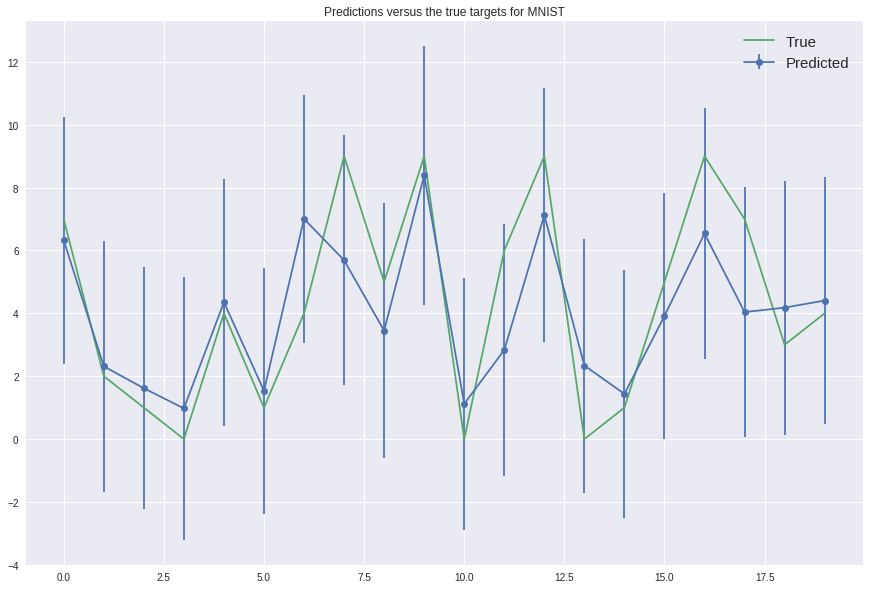

In [97]:
limit = 20
plt.figure(figsize=(15,10))
plt.title('Predictions versus the true targets for MNIST')
plt.errorbar(range(limit), mnist_pred_mean[:limit], yerr=mnist_pred_var[:limit]*1e-12, fmt='o-', label="Predicted")
plt.plot(range(limit), mnist_test_label[:limit], label="True")
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, prop={'size':15})

plt.show()

In [98]:
mnist_pred_mean_disc = np.array([my_round(pred) for pred in mnist_pred_mean])
mnist_acc = get_accuracy(mnist_pred_mean_disc, mnist_test_label)/100
mnist_mse = mean_squared_error(mnist_test_label, mnist_pred_mean)
print("MNIST accuracy:", mnist_acc)
print("Order %d - MNIST Accuracy: %.2f" %(order,mnist_acc))
print("MSE for MNIST:", mnist_mse)

22.989999999999998

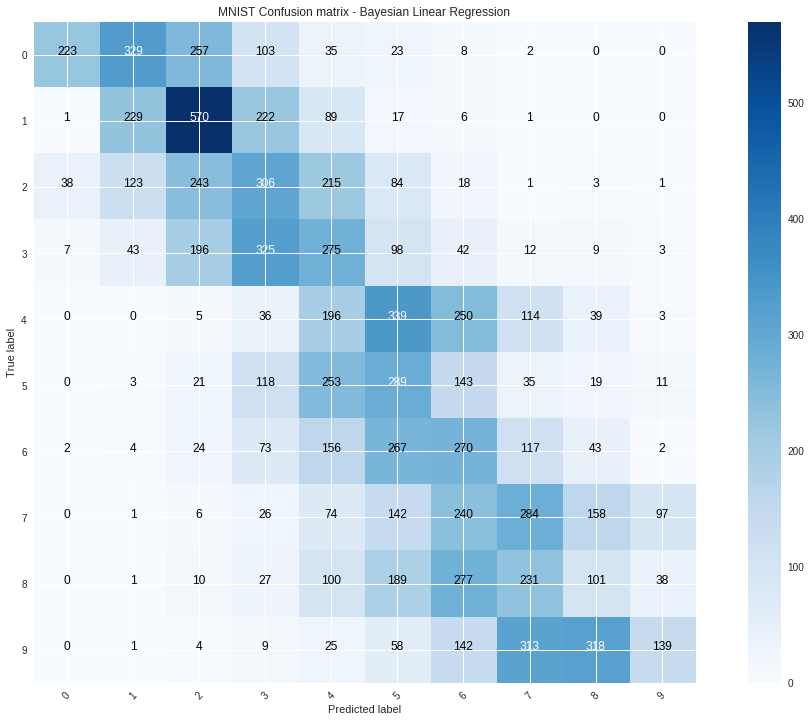

In [103]:
mnist_conf_matrix_bayes = confusion_matrix(mnist_test_label, mnist_pred_mean_disc)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,10))
plot_confusion_matrix(mnist_conf_matrix_bayes, classes=range(10),
                      title='MNIST Confusion matrix - Bayesian Linear Regression')
plt.show()

## Another approach

In [21]:
def get_w_hat(X, t):
#     eps = 1e-3 # add a bit of noise to avoid singular matrix
    XTX = X.T.dot(X) + np.diag(np.random.uniform(0, 1, X.T.shape[0]))
    return np.dot(np.linalg.inv(XTX), X.T.dot(t)), XTX
#     return np.dot(np.linalg.inv(X.T.dot(X) + np.diag(np.random.uniform(0, 1, X.T.shape[0]))), X.T.dot(t))


def get_predictions(x, t, x_test, order = 1):
    X = get_X(x, order) # Ntrain x len(image)*order
    X_test = get_X(x_test, order) # Ntest x len(image)*order
    w_hat, XTX = get_w_hat(X, t) # len(image)*order, len(image)*order x len(image)*order
    tXw = t - X.dot(w_hat) # Ntrain
    sigma2_hat  = tXw.T.dot(tXw)/len(t); # float
    XTX_inv = np.linalg.inv(XTX) # len(image)*order x len(image)*order
#     print("XTX_inv ", XTX_inv.shape)
    sigma2_hat_X_test = sigma2_hat*(X_test) # Ntest x len(image)*order
#     print("sigma2_hat_X_test ", sigma2_hat_X_test.shape)
    sigma2_test = np.zeros(len(x_test))
    for i in range(len(x_test)):
        sigma2_test[i] = sigma2_hat_X_test[i].dot(XTX_inv).dot(X_test[i]) #
#     print(sigma2_test.shape)
    return X_test.dot(w_hat), sigma2_test
#     X = get_X(x, order)
#     X_test = get_X(x_test, order)
#     w_hat = get_w_hat(X, t)
#     return X_test.dot(w_hat)

In [25]:
order = 1
t0 = time()
predictions_mnist, sigma2_test_mnist = get_predictions(mnist_train_data_norm, mnist_train_label, mnist_test_data_norm, order)
print("Time needed:", time()-t0)
# predictions_mnist = get_predictions(mnist_train_data_norm, mnist_train_label, mnist_test_data_norm, order)
predictions_mnist_disc = np.array([my_round(pred) for pred in predictions_mnist]) 
accuracy_mnist = get_accuracy(predictions_mnist_disc, mnist_test_label)/100
mnist_mse = mean_squared_error(mnist_test_label, predictions_mnist)
print("Order %d - MNIST Accuracy: %.2f" %(order,accuracy_mnist))
print("MSE for MNIST:", mnist_mse)


Time needed: 22.468737602233887
Order 1 - MNIST Accuracy: 23.07
MSE for MNIST: 3.14961270912


Let's try to predict the CIFAR dataset.

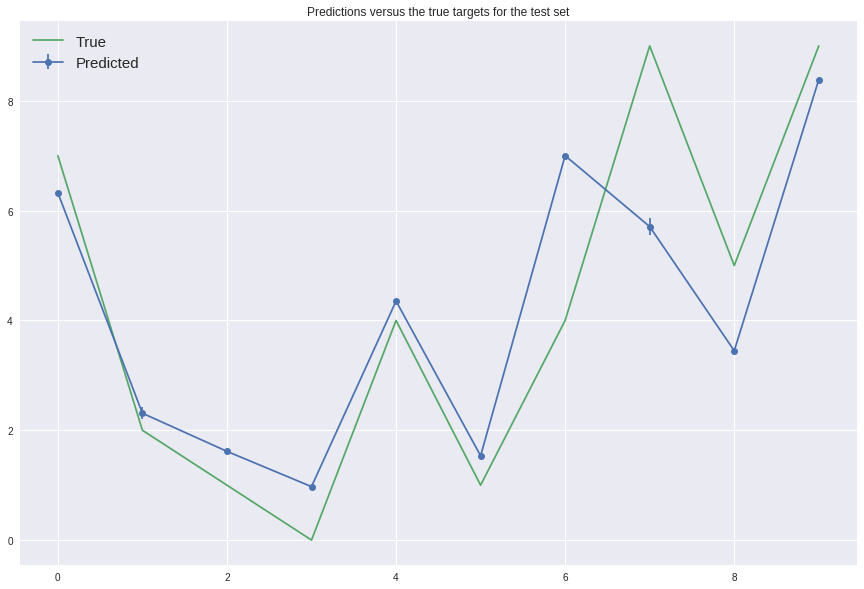

In [26]:
limit = 10
plt.figure(figsize=(15,10))
plt.title('Predictions versus the true targets for MNIST')
plt.errorbar(range(limit), predictions_mnist[:limit], yerr=sigma2_test[:limit], fmt='o-', label="Predicted")
plt.plot(range(limit), mnist_test_label[:limit], label="True")
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, prop={'size':15})

plt.show()

Let's try with different orders.

In [116]:
for order in [1, 2, 3, 4]:
    t0 = time()
    predictions_mnist = get_predictions(mnist_train_data_norm, mnist_train_label, mnist_test_data_norm, order)
    print("Time for order %d: %.2f seconds" %(order, time()-t0))
    prediction_mnist_disc = np.array([my_round(pred) for pred in predictions_mnist]) 
    
    print('Accuracy Bayesian Linear Regression (order %d): %.2f%%' \
                      % (order, get_accuracy(prediction_mnist_disc, mnist_test_label)/100))

Time for order 1: 3.26 seconds
Accuracy Bayesian Linear Regression (order 1): 23.05%
Time for order 2: 9.95 seconds
Accuracy Bayesian Linear Regression (order 2): 28.33%
Time for order 3: 31.75 seconds
Accuracy Bayesian Linear Regression (order 3): 28.71%
Time for order 4: 43.69 seconds
Accuracy Bayesian Linear Regression (order 4): 28.91%


In [26]:
order = 1
t0 = time()
predictions_cifar, sigma2_test_cifar = get_predictions(cifar_train_data_norm, cifar_train_label, cifar_test_data_norm, order)
print("Time needed:", time()-t0)
prediction_cifar_disc = np.array([my_round(pred[0]) for pred in predictions_cifar]) 
accuracy_cifar = get_accuracy(prediction_cifar_disc, cifar_test_label)/100
cifar_mse = mean_squared_error(cifar_test_label, predictions_cifar)
print("Order %d - CIFAR Accuracy: %.2f" %(order,accuracy_cifar))
print("MSE for CIFAR:", cifar_mse)

Time needed: 350.4151005744934
Order 1 - CIFAR Accuracy: 11.34
MSE for CIFAR: 7.898902559


<div class="alert alert-info">
d) (text) Suggest a way to discretize predictions and display the confusion matrix on the
test data and report accuracy [5]
</div>
A possible way to discretize predictions is to round them to the closest integer number. In addition, one could map all negative values to 0 and all labels greater than 9 to 9.

<div class="alert alert-info">
e) (text) Discuss regression performance with respect to classification performance [5]
</div>

<div class="alert alert-info">
f) (text) Describe one limitation of using regression for this particular task. [5]
</div>


5) Bonus question
- a) (text / code) The state-of-the-art in these image classification problems suggests that
convolutional layers in convolutional neural networks yield most of the improvements
compared to standard neural networks. The reason is that they are capable of
modeling spatial patterns through the hierarchical analysis of patches of images.
Propose and implement ways to exploit patch information in the Na誰ve Bayes
classifier or linear regression. A couple of suggestions are: (i) apply Na誰ve Bayes
classification to the output of convolutional layer in the LeNet architecture (ii) construct
the Na誰ve Bayes classifier by calculating patch-specific statistics and extend this by
stacking multiple of these.

Numbers at the end of each section are the number of marks available.
Be concise - a complete solution should be around 10 pages (including figures) and no more than 20.